In [1]:
from shapely.geometry import Polygon
import math
import pdb
import numpy as np
import random
import tensorflow as tf
tf.logging.set_verbosity(20)
import matplotlib.pyplot as plt

In [2]:
radii = range(10)
angular_division = 24

pixels = {}
for x in range(-sum(radii), sum(radii) + 1):
  for y in range(-sum(radii), sum(radii) + 1):
    p = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    pixels[(x, y)] = p

masks = [[[] for radius in range(len(radii) - 1)] for _ in range(angular_division)]
for ad in range(angular_division):
  for i, (r_inner, r_outer) in enumerate(zip(radii, radii[1:])):
    theta1 = 2 * math.pi / angular_division * ad
    theta2 = 2 * math.pi / angular_division * (ad + 1)
    ang_steps_counter_clockwise = np.linspace(theta1, theta2)
    inner_arc = []
    for ang_step in ang_steps_counter_clockwise:
      inner_arc.append([r_inner * math.cos(ang_step), r_inner * math.sin(ang_step)])
    ang_steps_clockwise = np.linspace(theta2, theta1)
    outer_arc = []
    for ang_step in ang_steps_clockwise:
      outer_arc.append([r_outer * math.cos(ang_step), r_outer * math.sin(ang_step)])
    mask_polygon = Polygon(inner_arc + outer_arc)
    minx, miny, maxx, maxy = mask_polygon.bounds
    for x in range(math.floor(minx), math.ceil(maxx) + 1):
      for y in range(math.floor(miny), math.ceil(maxy) + 1):
        pixel = pixels[(x, y)]
        if pixel.intersects(mask_polygon):
          area = mask_polygon.intersection(pixel).area
          if area != 0:
            masks[ad][i].append(((x, y), area))

In [3]:
np.multiply(np.zeros([10,1,4,4,1]), np.ones([7, 4,4,1])).shape

(10, 7, 4, 4, 1)

In [4]:
glimpse_size = (max(radii) + 1) * 2
mask_img = np.zeros([(len(radii) - 1) * angular_division, glimpse_size, glimpse_size, 1])
for angle in range(angular_division):
    for r in range(len(radii) - 1):
        for coord, area in masks[angle][r]:
            mask_img[angle * (len(radii) - 1) + r, coord[0] + glimpse_size // 2, coord[1] + glimpse_size // 2, 0] = area

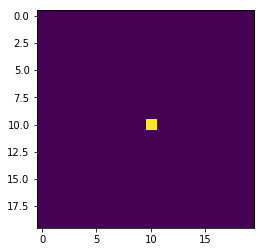

In [5]:
plt.imshow(mask_img[18,:,:,0])

In [6]:
mask_img.shape

(216, 20, 20, 1)

In [7]:
print(len(masks)) 
print(len(masks[0]))# the size of masks is angular_division x len(radii). each cell contains the pixels info overlapping with the arc (receptive field).

24
9


In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

9

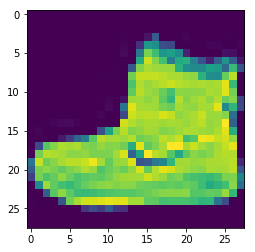

In [9]:
plt.imshow(x_train[0])
y_train[0]

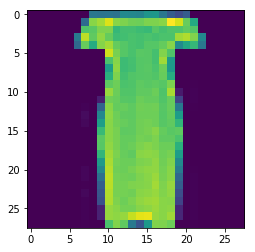

In [10]:
image = x_train[51]
plt.imshow(image)

In [11]:
mapped_image = np.zeros([angular_division, 40])
for a in range(angular_division):
  for r in range(14):
    mask_intensity = []
    areas = []
    for mask in masks[a][r]:
      x, y = mask[0]
      mask_intensity.append(image[x + 13, y + 13] * mask[1])
      areas.append(mask[1])
    mapped_image[a, r] = np.sum(mask_intensity) / np.sum(areas)

plt.imshow(mapped_image)

IndexError: list index out of range

In [12]:
def circular_fov_with_attention(features, labels, mode, params):
  if mode == tf.estimator.ModeKeys.TRAIN:
    is_training = True
  else:
    is_training = False

  images = features['x']
  images = tf.expand_dims(images, -1) # add channel to images
  lstm = tf.nn.rnn_cell.BasicRNNCell(16)
  state = lstm.zero_state(tf.shape(images)[0], dtype=tf.float32)
  loc = tf.random_uniform([tf.shape(images)[0], 2], minval=-1.0, maxval=1.0)
  projected_images = [[] for _ in range(angular_division)]#tf.Variable(tf.zeros([128, 21, angular_division, 1]))
  glimpse_size = 20
  # glimpse net
  for h in range(8):
    rectangular_glimpse = tf.image.extract_glimpse(images, [glimpse_size, glimpse_size], loc,)
    rectangular_glimpse = tf.expand_dims(rectangular_glimpse, axis=1)
    masked_images = tf.multiply(rectangular_glimpse, mask_img)
    masked_images = tf.reduce_sum(masked_images, [2, 3])
    polar_projected_images = tf.reshape(masked_images, [-1, angular_division, len(radii)-1, 1])
    #projected_images = [[] for _ in range(angular_division)]
    #for a in range(angular_division):
    #  for r in range(14):
    #    mask_intensity = []
    #    areas = []
    #    for mask in masks[a][r]:
    #      x, y = mask[0]
    #      mask_intensity.append(rectangular_glimpse[:, x + glimpse_size//2, y + glimpse_size//2, 0] * mask[1])
    #      areas.append(mask[1])
    #    mask_int = tf.reduce_sum(tf.stack(mask_intensity), 0) / np.sum(areas)
    #    #tf.print(mask_int, [mask_int])
    #    #projected_pixels = tf.tensordot(mask_int, tf.convert_to_tensor(areas), axes=[1, 0])
    #    #pdb.set_trace()
    #    #projected_pixels = tf.reduce_sum(tf.multiply(mask_int, tf.convert_to_tensor(areas)), axis=1)
    #    projected_images[a].append(mask_int)
    #  projected_images[a] = tf.stack(projected_images[a])
    #pdb.set_trace()
    #projected_images = tf.stack(projected_images)
    #projected_images = tf.transpose(projected_images, [2, 0, 1])
    #projected_images = tf.expand_dims(projected_images, -1)
    #projected_images = tf.concat([projected_images[:, -2:, :, :], projected_images, projected_images[:, :2, :, :]], axis=1)
    
    net = tf.layers.conv2d(
        inputs=polar_projected_images,#projected_images,
        filters=16,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name='conv1',
        reuse=tf.AUTO_REUSE
    )
    net = net[:, 2:-2, :, :]
    net = tf.concat([net[:, -2:, :, :], net, net[:, :2, :, :]], axis=1)
    net = tf.layers.conv2d(
        inputs=net,
        filters=32,
        kernel_size=[3, 3],
        padding='same',
        activation=tf.nn.relu,
        name='conv2',
        reuse=tf.AUTO_REUSE
        )
    net = net[:, 2:-2, :, :]
    net = tf.layers.flatten(net)
    # core network
    output, state = lstm(net, state)
    logits = tf.layers.dense(output, 10, name='logits', reuse=tf.AUTO_REUSE)
    
    # location network?
    loc_mean = tf.layers.dense(output, 2, name='loc', reuse=tf.AUTO_REUSE)
    dist = tf.distributions.Normal(loc_mean, 0.1)
    loc = dist.sample(1)
    policy = tf.reduce_prod(dist.prob(loc), -1) # pi(a_t|s_t)
    loc = tf.squeeze(loc)
    loc = tf.clip_by_value(loc, -1., 1.)
    
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits,)
  
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.003)
    optimizer_policy = tf.train.GradientDescentOptimizer(1)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      attention_scopes = ['loc',]
      grads_and_vars = optimizer.compute_gradients(loss)
      grads_and_vars = [(grad_and_var[0], grad_and_var[1]) for grad_and_var in grads_and_vars if grad_and_var[0] is not None]
      vars_motor = [tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope) for scope in attention_scopes]
      grads_and_vars_policy = []
      for hh in range(h - 1):
          grads_and_vars_policy.append(optimizer_policy.compute_gradients(-(loss - tf.reduce_sum(loss)) * tf.log(loc[hh]), vars_motor))
      train_motor_ops = []
      for update in grads_and_vars_policy:
          motor_op = optimizer_policy.apply_gradients(update, global_step=tf.train.get_global_step())
          train_motor_ops.append(motor_op)
      
      train_sensory_op = optimizer.apply_gradients(grads_and_vars, global_step=tf.train.get_global_step())
      train_op = tf.group(train_sensory_op, *train_motor_ops)
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op,)# training_hooks = [logging_hook])

  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, )#eval_metric_ops=metrics)

In [13]:
def translate(data, size=60):
  translated_data = []
  for i in range(len(data)):
    offset = [random.randrange(size - 28), random.randrange(size - 28)]
    pad_width = ((offset[0], size - 28 - offset[0]), (offset[1], size - 28 - offset[1]))
    translated_data.append(np.pad(data[i], pad_width, 'constant'))
  return np.array(translated_data)

In [14]:
y_train.shape

(60000,)

In [17]:
session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
estimator_config = tf.estimator.RunConfig(session_config=session_config)

classifier = tf.estimator.Estimator(model_fn=circular_fov_with_attention, config=estimator_config)#model_dir='/content/gdrive/My Drive/test1')
x_train = translate(x_train, 60)
#eval_data = translate(eval_data, 60)
x_text = translate(x_test, 60)

num_epochs = 100
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train.astype(np.float32)},
    y=y_train.astype(np.int32),
    batch_size=64,
    #queue_capacity=len(x_train),
    shuffle=True,
    num_epochs=num_epochs)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train.astype(np.float32)},
    y=y_train.astype(np.int32),
    batch_size=64,
    shuffle=False)

#test_input_fn = tf.estimator.inputs.numpy_input_fn(
#    x={"x": test_data},
#    y=None,
#    batch_size=128,
#    shuffle=False
#)

steps_per_epoch = len(x_train) / 64

train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=steps_per_epoch * num_epochs)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn,)
tf.estimator.train_and_evaluate(classifier, train_spec, eval_spec, )

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmojz0y5f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f09c743c550>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_check

INFO:tensorflow:global_step/sec: 31.8883
INFO:tensorflow:global_step/sec: 32.4616
INFO:tensorflow:global_step/sec: 32.2641
INFO:tensorflow:global_step/sec: 32.3634
INFO:tensorflow:global_step/sec: 32.123
INFO:tensorflow:global_step/sec: 32.683
INFO:tensorflow:loss = 2.3212185, step = 15407 (21.649 sec)
INFO:tensorflow:global_step/sec: 32.4678
INFO:tensorflow:global_step/sec: 32.14
INFO:tensorflow:global_step/sec: 32.1687
INFO:tensorflow:global_step/sec: 32.3687
INFO:tensorflow:global_step/sec: 32.2018
INFO:tensorflow:global_step/sec: 31.7894
INFO:tensorflow:loss = 2.3208442, step = 16106 (21.718 sec)
INFO:tensorflow:global_step/sec: 32.3299
INFO:tensorflow:global_step/sec: 32.1942
INFO:tensorflow:global_step/sec: 32.5696
INFO:tensorflow:global_step/sec: 31.9853
INFO:tensorflow:global_step/sec: 32.1341
INFO:tensorflow:global_step/sec: 31.919
INFO:tensorflow:global_step/sec: 32.3398
INFO:tensorflow:loss = 2.3073583, step = 16806 (21.745 sec)
INFO:tensorflow:global_step/sec: 32.0617
INFO:

INFO:tensorflow:loss = 2.3247356, step = 30805 (21.743 sec)
INFO:tensorflow:global_step/sec: 32.1787
INFO:tensorflow:global_step/sec: 32.0252
INFO:tensorflow:global_step/sec: 31.8768
INFO:tensorflow:global_step/sec: 32.2552
INFO:tensorflow:global_step/sec: 32.4956
INFO:tensorflow:global_step/sec: 32.2187
INFO:tensorflow:loss = 2.2927403, step = 31505 (21.748 sec)
INFO:tensorflow:global_step/sec: 32.0539
INFO:tensorflow:global_step/sec: 32.3095
INFO:tensorflow:global_step/sec: 32.3058
INFO:tensorflow:global_step/sec: 31.865
INFO:tensorflow:global_step/sec: 31.8449
INFO:tensorflow:global_step/sec: 32.013
INFO:tensorflow:loss = 2.3004074, step = 32205 (21.845 sec)
INFO:tensorflow:global_step/sec: 32.035
INFO:tensorflow:global_step/sec: 32.3598
INFO:tensorflow:global_step/sec: 32.1223
INFO:tensorflow:global_step/sec: 32.2127
INFO:tensorflow:global_step/sec: 32.0781
INFO:tensorflow:global_step/sec: 32.554
INFO:tensorflow:loss = 2.3252895, step = 32905 (21.705 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 32.113
INFO:tensorflow:loss = 2.3116665, step = 46903 (21.593 sec)
INFO:tensorflow:global_step/sec: 32.4175
INFO:tensorflow:global_step/sec: 32.386
INFO:tensorflow:global_step/sec: 32.5457
INFO:tensorflow:global_step/sec: 32.2988
INFO:tensorflow:global_step/sec: 32.5196
INFO:tensorflow:global_step/sec: 32.3273
INFO:tensorflow:global_step/sec: 32.7217
INFO:tensorflow:loss = 2.3243532, step = 47603 (21.559 sec)
INFO:tensorflow:global_step/sec: 32.5241
INFO:tensorflow:global_step/sec: 31.986
INFO:tensorflow:global_step/sec: 32.5959
INFO:tensorflow:global_step/sec: 32.2875
INFO:tensorflow:global_step/sec: 32.123
INFO:tensorflow:global_step/sec: 32.4021
INFO:tensorflow:loss = 2.333364, step = 48303 (21.665 sec)
INFO:tensorflow:global_step/sec: 32.7598
INFO:tensorflow:global_step/sec: 33.0578
INFO:tensorflow:global_step/sec: 32.9518
INFO:tensorflow:global_step/sec: 32.2799
INFO:tensorflow:global_step/sec: 32.9735
INFO:tensorflow:global_step/sec: 32.5881
INFO:

INFO:tensorflow:global_step/sec: 32.1756
INFO:tensorflow:global_step/sec: 32.1257
INFO:tensorflow:global_step/sec: 32.5332
INFO:tensorflow:loss = 2.3170404, step = 63000 (21.769 sec)
INFO:tensorflow:global_step/sec: 32.1075
INFO:tensorflow:global_step/sec: 32.617
INFO:tensorflow:global_step/sec: 32.4399
INFO:tensorflow:global_step/sec: 32.05
INFO:tensorflow:global_step/sec: 32.7436
INFO:tensorflow:global_step/sec: 32.9516
INFO:tensorflow:loss = 2.3151875, step = 63700 (21.493 sec)
INFO:tensorflow:global_step/sec: 32.7108
INFO:tensorflow:global_step/sec: 32.3806
INFO:tensorflow:global_step/sec: 32.9986
INFO:tensorflow:global_step/sec: 32.6578
INFO:tensorflow:global_step/sec: 33.0868
INFO:tensorflow:global_step/sec: 32.6544
INFO:tensorflow:global_step/sec: 33.0525
INFO:tensorflow:loss = 2.3039763, step = 64400 (21.338 sec)
INFO:tensorflow:global_step/sec: 32.9772
INFO:tensorflow:global_step/sec: 31.9646
INFO:tensorflow:global_step/sec: 32.7422
INFO:tensorflow:global_step/sec: 32.841
INFO

INFO:tensorflow:global_step/sec: 32.8742
INFO:tensorflow:global_step/sec: 33.2681


KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
ax = plt.subplot(121, projection='polar')
ax.set_thetagrids(np.arange(36) / 36 * 360, labels=[])

ax.plot([0, 0], [0, 1], color='r', linewidth=3)
ax.plot([0.2, 0.02], [0.01, 1], linewidth=2)
ax.set_rlim([0, 1])
ax.set_rticks(np.arange(15)/15, )
ax.set_yticklabels([])
ax.plot(np.arange(500)/500*2*np.pi, [1]*500, color='purple', linewidth=4)
ax.scatter([0],[0], color='k', s=100)
ax.spines['polar'].set_color('purple')
ax2 = plt.subplot(122,)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xticks(np.arange(36)/36,)
ax2.set_yticks(np.arange(15)/15)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(True)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, top=False)
ax2.spines['top'].set_color('purple')
ax2.spines['left'].set_color('r')
ax2.spines['bottom'].set_color('k')
ax2.spines['right'].set_color('b')
ax2.hlines(0, 0, 1, color='k', linewidth=4)
ax2.hlines(1, 0, 1, color='purple', linewidth=4)
ax2.plot([0, 0], [0, 1], linewidth=4, color='r')
ax2.plot([1,1], [0, 1], linewidth=5, color='b')
ax2.set_aspect(15/36)
plt.show()